# Metacritic All Time Games Statistics (1995 - 2018)

For this project, we used a dataset on Metacritic Games Reviews and Ratings from this kaggle page: https://www.kaggle.com/skateddu/metacritic-all-time-games-stats. Our goal is to ....


First, we import the necessary libraries:

In [59]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns; sns.set()
import numpy as np
import requests
import json
import pymongo
from scipy import stats 
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import itertools 

In [60]:
# Functions

def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

def welch_t(a, b):
    numerator = a.mean() - b.mean()
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p
    
def effect_size(a, b):
    e = a.mean()-b.mean()
    
    return e

Next we import the dataset and preview the dataframe in pandas.

In [3]:
# Import dataset csv and preview
df = pd.read_csv('metacritic_games.csv')
df.head()

,name,platform,developer,publisher,genre,players,rating,attribute,release_date,link,critic_positive,critic_neutral,critic_negative,metascore,user_positive,user_neutral,user_negative,user_score
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,01-Apr,T,NaN,"Aug 31, 1995",/game/pc/command-conquer,5,0,0,94,47,0,1,8.9
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,NaN,NaN,NaN,"Apr 30, 1995",/game/pc/full-throttle,6,2,0,86,18,1,0,8.7
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,01-Feb,T,NaN,"Sep 9, 1995",/game/playstation/battle-arena-toshinden,1,3,0,69,1,0,1,5.8
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,1 Player,K-A,NaN,"Feb 29, 1996",/game/pc/sid-meiers-civilization-ii,7,0,0,94,46,0,1,8.9
4,Quake,PC,id Software,id Software,Action,Jan-16,M,NaN,"Jun 22, 1996",/game/pc/quake,9,0,0,94,84,4,1,8.8


## Data Cleaning

### Removing incomplete rows and redundant columns

We begin data cleaning by dropping rows with missing values in developer and publisher.

In [4]:
# Drop rows with missing values in developer and publisher
df.dropna(subset=['developer', 'publisher'], inplace = True)
df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

The following columns are dropped as they are not relevant to our research question:

In [5]:
# Drop redundant columns
df = df.drop(['players', 'attribute', 'link', 'critic_positive',
              'critic_neutral', 'critic_negative','user_positive',
              'user_neutral', 'user_negative'], axis = 1)

### Obtaining Release Year

Next, we sliced the 'release_date' to obtain the year of release and replaced the column with the appropriate 'release_year' data.

In [6]:
# Change Release Date to Release Year
year_released = []
for i in range(0,len(df['release_date'])):    
    year_released.append(df.release_date[i].split()[2])
    
df['release_date'] = year_released
df.rename(columns={"release_date": "release_year"}, inplace = True)

# Change datatype from str to integer
df[['release_year']] = df[['release_year']].astype(int)

### Rating

Rating columns are adjusted by replacing the letters with the actual rating description, as follows:
* **E** = Everyone
* **EC** = Early Childhood 3+
* **E10+** = Everyone 10+
* **T** = Teen 13+
* **M** = Mature 17+
* **AO** = Adults Only 18+
* **RP** or **K-A** = Rating Pending
* **Null values** are replaced as Rating Pending

In [7]:
# Add Description to Rating column and remove null values
for rating in df['rating']:
    if rating == 'E':
        df.rating.replace(to_replace = rating, value = 'Everyone', inplace=True)
    elif rating == 'EC':
        df.rating.replace(to_replace = rating, value = 'Early Childhood 3+', inplace=True)
    elif rating == 'E10+':
        df.rating.replace(to_replace = rating, value = 'Everyone 10+', inplace=True)
    elif rating == 'T':
        df.rating.replace(to_replace = rating, value = 'Teen 13+', inplace=True)
    elif rating == 'M':
        df.rating.replace(to_replace = rating, value = 'Mature 17+', inplace=True)
    elif rating == 'AO':
        df.rating.replace(to_replace = rating, value = 'Adults Only 18+', inplace=True)
    elif rating == 'RP' or rating == 'K-A' or type(rating) == float:
        df.rating.replace(to_replace = rating, value = 'Rating Pending', inplace=True)

### Adjusting User Score

The user_score column contains 0 null values, however 'tbd' is present, representing the user score is to be determined. As there are 2000 + values of 'tbd', we will replace the values with random-assigned values with weighted probabilities from other user review scores

In [8]:
# Assign 'tbd' values with random-assigned values with weighted probablities
choice = sorted(df[df.user_score != 'tbd']['user_score'].unique())
prob = df[df.user_score != 'tbd']['user_score'].value_counts(normalize=True).sort_index()
df['user_score'] = df.user_score.map(lambda x: np.random.choice(choice, 1, p= prob)[0] if x == 'tbd' else x)

For comparison purposes, we will adjust the user_score to be in the same format as the metascore by multiplying all values by 10 as user_score is rated on a scale of 10 while metascore is rated on a scale of 100. Appropriate datatype conversion will be performed to the values.

In [9]:
# Change datatype from str to float
df[['user_score']] = df[['user_score']].astype(float)

# Change user_score from a scale of 10 to a scale of 100 by multiplying all values by 10
df['user_score'] = df['user_score'].apply(lambda x: x * 10 )

# Change datatype from float to int
df[['user_score']] = df[['user_score']].astype(int)

In [10]:
print(df.shape)
df.head()

(20380, 9)


,name,platform,developer,publisher,genre,rating,release_year,metascore,user_score
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,Teen 13+,1995,94,89
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,Rating Pending,1995,86,87
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,Teen 13+,1995,69,58
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,Rating Pending,1996,94,89
4,Quake,PC,id Software,id Software,Action,Mature 17+,1996,94,88


Great! We now have a clean dataframe in the right format with no missing values. The dataframe has a shape of **9 columns x 20380 rows**. We can now begin our data analysis and hypothesis testing.

## Data Analysis 

In [11]:
# platform_boolean = []
# for platform in df['platform']:
#     if platform == 'PC':
#         platform_boolean.append('PC')
#     else:
#         platform_boolean.append('Console')
# df['platform_bool'] = platform_boolean

# Segment our data into few ranges of years for analysis
year_boolean = []
for year in df['release_year']:
    if year == 2013 or year == 2014:
        year_boolean.append('13-14')
    elif year == 2015 or year == 2016:
        year_boolean.append('15-16')
    elif year == 2017 or year == 2018:
        year_boolean.append('17-18')
    elif year < 2013:
        year_boolean.append('Others')
df['year_bool'] = year_boolean

# To check average score between metascore and user score
avg_score = []
for i in range(0,len(df)):
    avg_score.append((df.metascore[i] + df.user_score[i])/2)
df['avg_score'] = avg_score

# To display the description of the scoring system
score_indication = []
for score in df['avg_score']:
    if score >= 90:
        score_indication.append('Universal Acclaim')
    elif score >= 75 and score <= 89:
        score_indication.append('Favorable')
    elif score >= 50 and score <= 74:
        score_indication.append('Average')
    elif score >= 20 and score <= 49:
        score_indication.append('Unfavorable')
    else:
        score_indication.append('Overwhelming Dislike')
df['score_indication'] = score_indication 

In [12]:
# Re-index the column order
df = df.reindex(columns=['name', 'platform', 'developer','publisher',
                         'genre', 'rating', 'release_year','year_bool', 
                         'metascore', 'user_score', 'avg_score', 'score_indication'])
df.head()

,name,platform,developer,publisher,genre,rating,release_year,year_bool,metascore,user_score,avg_score,score_indication
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,Teen 13+,1995,Others,94,89,91.5,Universal Acclaim
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,Rating Pending,1995,Others,86,87,86.5,Favorable
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,Teen 13+,1995,Others,69,58,63.5,Average
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,Rating Pending,1996,Others,94,89,91.5,Universal Acclaim
4,Quake,PC,id Software,id Software,Action,Mature 17+,1996,Others,94,88,91.0,Universal Acclaim


In [13]:
actiondf = df[df.genre == 'Action']
actiondf.user_score.groupby([df.year_bool,df.genre]).describe()

,,count,mean,std,min,25%,50%,75%,max
year_bool,genre,,,,,,,,
13-14,Action,780.0,66.507692,14.152160,10.0,60.0,70.0,76.0,89.0
15-16,Action,943.0,66.913043,13.361337,4.0,61.0,69.0,76.0,90.0
17-18,Action,1089.0,67.395776,13.733828,10.0,61.0,70.0,77.0,90.0
Others,Action,4288.0,70.035681,14.456127,8.0,63.0,74.0,80.0,92.0


In [14]:
actiondf_1314 = actiondf[actiondf['year_bool'] == '13-14']
actiondf_1516 = actiondf[actiondf['year_bool'] == '15-16']
actiondf_1718 = actiondf[actiondf['year_bool'] == '17-18']

In [15]:
sample_1314 = actiondf_1314.sample(100)
sample_1516 = actiondf_1516.sample(100)
sample_1718 = actiondf_1718.sample(100)

In [16]:
sample_merged = pd.concat([sample_1314, sample_1516, sample_1718])

In [17]:
sample_merged['user_score'].groupby(by = sample_merged.year_bool).describe()

,count,mean,std,min,25%,50%,75%,max
year_bool,,,,,,,,
13-14,100.0,65.32,14.996215,26.0,56.75,69.0,76.00,88.0
15-16,100.0,67.19,13.160774,12.0,62.75,70.0,76.00,88.0
17-18,100.0,67.50,14.202361,12.0,61.00,71.0,78.25,86.0


In [18]:
formula = 'user_score ~ C(year_bool)'
lm = ols(formula, sample_merged).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                 df    sum_sq     mean_sq         F    PR(>F)
C(year_bool)    2.0    278.18  139.090000  0.695682  0.499545
Residual      297.0  59380.15  199.933165       NaN       NaN


In [19]:
mc = MultiComparison(sample_merged.user_score, sample_merged.year_bool)
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 13-14  15-16     1.87 0.6092 -2.8405 6.5805  False
 13-14  17-18     2.18 0.5205 -2.5305 6.8905  False
 15-16  17-18     0.31    0.9 -4.4005 5.0205  False
---------------------------------------------------


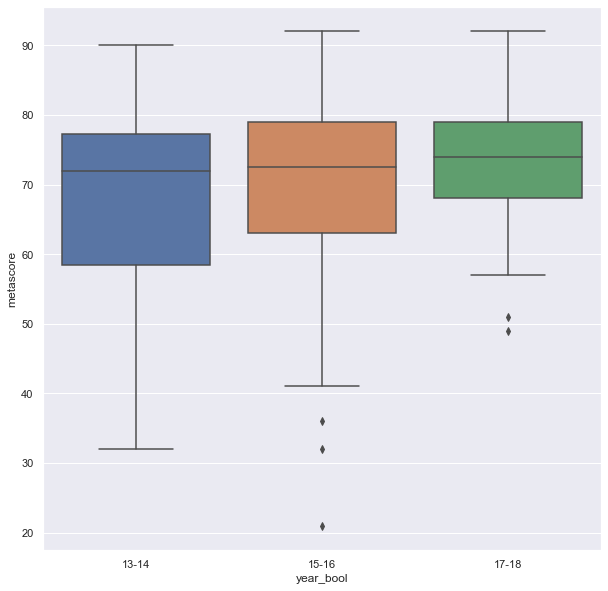

In [83]:
fig = plt.subplots(figsize = (10,10))
sns.boxplot(x='year_bool', y='metascore', data=sample_merged)

# Atlus vs Zen Studios vs Ubisoft

For this hypothesis test, we aim to compare 3 publishing powerhouses in the gaming industry, namely Atlus, Ubisoft and Zen Studios. 
* Atlus is a japanese company, known for their Sega games like Super Sonic and work closely with Nintendo games developer.
* Ubisoft is one of the top gaming developer and publisher, known for famous RPG games like the Assassin's Creed and Tom Clancy series.
* Zen Studios is a Hungarian company focuses on simplistic revamped classic games like Pinball and CastleStorm.

The goal of this experiment is to see which publisher/distributer performs better with the critics, given their reputation.

* **H0 : The 3 companies perform equally well on metascore**
* **H1 : The 3 companies do not perform equally well on metascore**

In [39]:
df_ubisoft = df[df.publisher == 'Ubisoft']
df_atlus = df[df.publisher == 'Atlus']
df_zen = df[df.publisher == 'Zen Studios']

In [95]:
sample_ubisoft = df_ubisoft.sample(50)
sample_atlus = df_atlus.sample(50)
sample_zen = df_zen.sample(50)

sample_merged = pd.concat([sample_ubisoft,sample_atlus, sample_zen])

We first plot the boxplot comparison to visually inspect the difference between mean, as below:

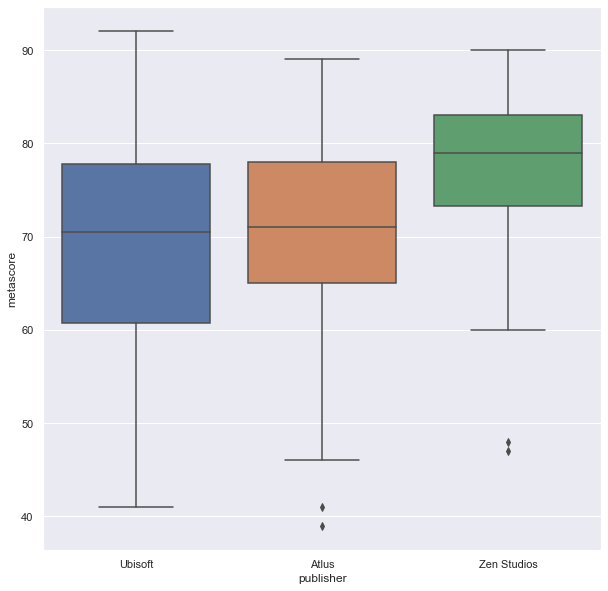

In [73]:
fig = plt.subplots(figsize = (10,10))
sns.boxplot(x='publisher', y='metascore', data=sample_merged)

Before proceeding to ANOVA testing, we do a quick normality check to see if we satisfies the normality condition for ANOVA.

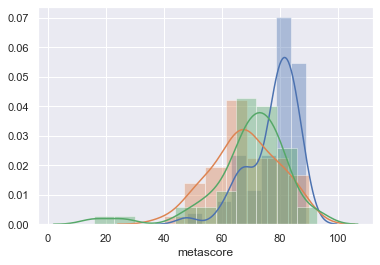

In [96]:
sns.distplot(sample_zen.metascore)
sns.distplot(sample_ubisoft.metascore)
sns.distplot(sample_atlus.metascore)

In [98]:
scipy.stats.normaltest(sample_zen.metascore)
scipy.stats.normaltest(sample_atlus.metascore)
scipy.stats.normaltest(sample_ubisoft.metascore)

NormaltestResult(statistic=0.49142554371137653, pvalue=0.7821468472525215)

As we are comparing 3 groups, we take 50 random samples from each group and conduct an ANOVA to check for statistically siginificant F-value and P-value to proceed with our analysis.

In [74]:
formula = 'metascore ~  C(publisher)'
lm = ols(formula, sample_merged).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                 df    sum_sq     mean_sq         F    PR(>F)
C(publisher)    2.0   1956.04  978.020000  7.866362  0.000568
Residual      147.0  18276.42  124.329388       NaN       NaN


From the ANOVA result, we can see a p-value of 0.005, which indicates statistical significance as it is below alpha value of 0.05. We then proceed to perform a Tukey multiple comparison test.

In [75]:
mc = MultiComparison(sample_merged.metascore, sample_merged.publisher)
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2   meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Atlus     Ubisoft    -0.46    0.9 -5.7405  4.8205  False
  Atlus Zen Studios     7.42 0.0032  2.1395 12.7005   True
Ubisoft Zen Studios     7.88 0.0016  2.5995 13.1605   True
----------------------------------------------------------


From the Tukey results table, we can see that for Atlus vs Ubisoft, the null hypothesis was not rejected while the null hypothesis was rejected when Zen Studios was compared against Atlus and Ubisoft.

In [76]:
print(f"The effect size observed between Atlus and Zen Studios is {(cohen_d(sample_atlus.metascore, sample_zen.metascore))}")
print(f"The effect size observed between Ubisoft and Zen Studios is {(cohen_d(sample_ubisoft.metascore, sample_zen.metascore))}")

The effect size observed between Atlus and Zen Studios is 0.7171919549313904
The effect size observed between Ubisoft and Zen Studios is 0.719200423105961


# Hypothesis 3

In [96]:
PC_df = df[df.platform == 'PC']

meta_sample = PC_df["metascore"]
user_sample = PC_df["user_score"]

In [97]:
welch_t(meta_sample,user_sample)

6.109717144616039

In [98]:
welch_df(meta_sample, user_sample)

10746.343973457178

In [99]:
p_value(meta_sample, user_sample)

5.163274252595329e-10

In [100]:
cohen_d(meta_sample, user_sample)

0.1173103231670341

In [102]:
effect_size(meta_sample, user_sample)

1.5494930875576074